# Task b

Frederik Rogge, Mouhammad Abu Rasheed and Homa Priya Tarigopula

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
import matplotlib.pyplot as plt
from sklearn.utils import resample
import os
%matplotlib inline

from utils import *
from resampling import *
np.random.seed(0)


In [2]:
# Create data
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)

# Compute z
z = FrankeFunction(x, y)

# Create features as pairs of (x, y)
features = np.stack([x.ravel(), y.ravel()], axis=1)


# Get labels
labels = z.ravel()
labels = labels.reshape((-1,1))


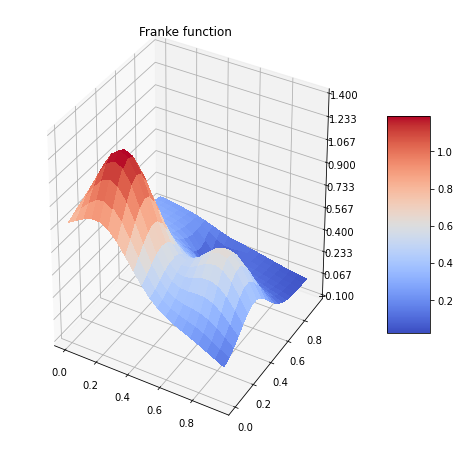

In [3]:
def plot_function(x, y, z, title=None):
    # Plot function
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if title is not None:
        plt.title(title)
    
    plt.show()
    
plot_function(x, y, z, 'Franke function')

### Part b) : Bias Variance trade-off on Franke function

#### Refer task 1 for MSE as a function of complexity 

In [4]:
n_bootstraps =100

n_datapoints  = [0.5 , 0.75, 1.0]  # percentage of train datapoints(%)

degree_values = np.arange(1, 25)  # Specify degree of polynomial to be fitted

# define the model we want to use 
solver = LinearRegression

#define the input argumets for the solver 
solver_args ={ 'fit_intercept': False }

### Part b) : Bootstrap Resampling technique

In [5]:
def bootstrap(features, labels ,n_datapoints , degree_values, scaling= True , add_noise= True, mean = 0, std = 1, solver = LinearRegression, n_bootstraps = 1000,**solver_args):
  
    Maxpolydegree = np.max(degree_values)

    error_test = np.zeros((Maxpolydegree,  len(n_datapoints)))
    bias_test = np.zeros((Maxpolydegree,  len(n_datapoints)))
    variance_test = np.zeros((Maxpolydegree,  len(n_datapoints)))

    error_train = np.zeros((Maxpolydegree,  len(n_datapoints)))
    bias_train = np.zeros((Maxpolydegree,  len(n_datapoints)))
    variance_train = np.zeros((Maxpolydegree,  len(n_datapoints)))

    if add_noise :
        np.random.seed(1)
        labels_n = labels +  np.random.normal(mean, std, labels.shape )
    else :
        labels_n = labels
    
    # Hold out some test data that is never used in training.
    Xtrain, X_test, ytrain, y_test = train_test_split(features, labels_n, 
                                                        test_size=0.2, random_state = 2021)
   
    for n,k in enumerate(n_datapoints) :
      
        chosen_indices = np.random.choice(len(ytrain), int(k*len(ytrain)), replace=False)
        
        # choosing a  subset of train data points
        X_train, y_train =  Xtrain[chosen_indices], ytrain[chosen_indices]
    
        for nd, degree in enumerate(degree_values):
            # Input features transformation 
            poly = PolynomialFeatures(degree = degree, include_bias= False)
            x_train = poly.fit_transform(X_train)
            x_test = poly.fit_transform(X_test)

            if scaling:
                # Scale data
                scaler = StandardScaler(with_std=True)
                x_train= scaler.fit_transform(x_train)
                x_test = scaler.transform(x_test)
            else:
                x_train = x_train
                x_test = x_test
                
            bs = Bootstrap()
                    
            error_test[nd,n], bias_test[nd,n], variance_test[nd,n], error_train[nd,n], bias_train[nd,n], variance_train[nd,n] = bs.resample(x_train, x_test, y_train, y_test, solver, n_bootstraps= n_bootstraps,**solver_args)
            
            #print('Polynomial degree:', degree)
            #print('Error:', error_test[nd,n])
            #print('Bias^2:', bias_test[nd,n])
            #print('Var:', variance_test[nd,n])
            #print('{} >= {} + {} = {}'.format(error_test[nd,n], bias_test[nd,n], variance_test[nd,n], bias_test[nd,n]+variance_test[nd,n]))

    return error_test, bias_test, variance_test,error_train , bias_train , variance_train 


In [6]:
def gen_plot(n_datapoints, polynomial, estimated_mse, title , y_label, legend_label, fig_name):
    fig, ax = plt.subplots()
    for n,k in enumerate(n_datapoints):
        ax.plot(polynomial, np.log10(estimated_mse[:, n]), label= legend_label +', % of train data = '+ str(k)  )
        ax.set_xlabel('Polynomial degree')
        ax.set_ylabel( y_label)
        ax.set_xticks(polynomial)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        save_fig(fig , name =fig_name + legend_label )
    ax.set_title(title)
    plt.show()
    
    

#### Bootstrap bias variance tradeoff


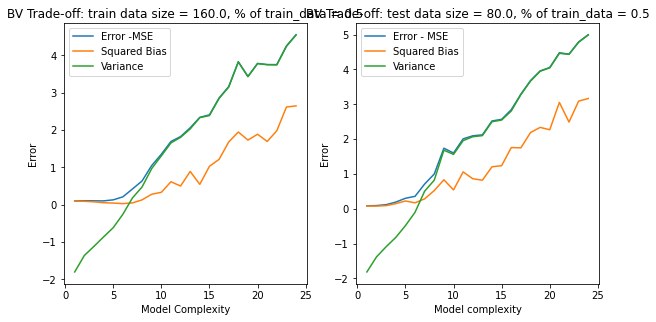

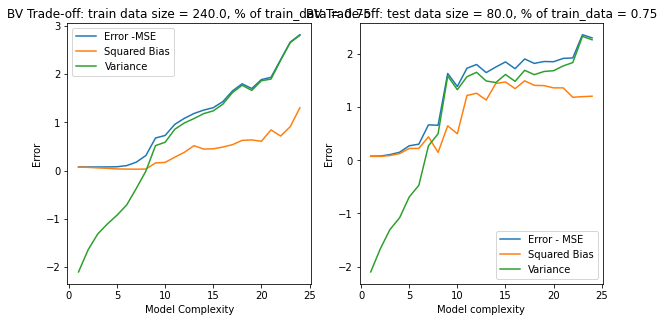

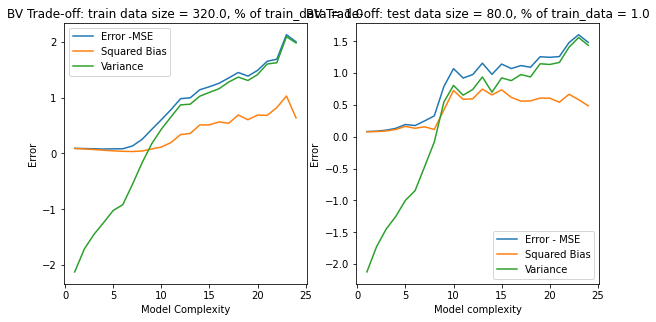

In [7]:
error_test, bias_test, variance_test,error_train , bias_train , variance_train = bootstrap(features, labels , n_datapoints, degree_values, 
                              scaling= True , add_noise= True, mean = 0, std = 1,
                             solver= solver,  n_bootstraps= n_bootstraps, **solver_args)

Maxpolydegree = np.max(degree_values)
polynomial = np.zeros(Maxpolydegree)

for polydegree in range(1, Maxpolydegree+1):
    polynomial[polydegree-1] = polydegree

    
# plot bias-variance tradeoff
for n,k in enumerate(n_datapoints): 
    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(4.8*2, 4.8))
    
    ax0.plot(polynomial, np.log10(error_train[:, n]), label= 'Error -MSE')
    ax0.plot(polynomial, np.log10(bias_train[:, n]), label= 'Squared Bias')
    ax0.plot(polynomial, np.log10(variance_train[:, n]), label= 'Variance')
    ax0.set_xlabel('Model Complexity')
    ax0.set_ylabel('Error')
    ax0.legend()
    ax0.set_title('BV Trade-off: train data size = '+str(np.round(k*0.8*len(labels), 2))+', % of train_data = '+ str(k))
    
    ax1.plot(polynomial, np.log10(error_test[:, n]), label= 'Error - MSE')
    ax1.plot(polynomial, np.log10(bias_test[:, n]), label= 'Squared Bias')
    ax1.plot(polynomial, np.log10(variance_test[:, n]), label= 'Variance')
    ax1.set_xlabel('Model complexity')
    ax1.set_ylabel('Error')
    ax1.legend()
    ax1.set_title('BV Trade-off: test data size = '+str(np.round(0.2*len(labels), 2))+', % of train_data = '+ str(k))
    
    save_fig(f, name ='b_bv_tradeoff_n_'+str(int(k*0.8*len(labels))))
    


#### Bootstrap Error with respect to complexity and datasize for train and test data

In [8]:
def plot_bootstrap(features, labels , n_datapoints, degree_values, fig_name,
                              scaling= True , add_noise= True, mean = 0, std = 1, solver= LinearRegression,  n_bootstraps= 1000, **solver_args):
    Maxpolydegree = np.max(degree_values)
    polynomial = np.zeros(Maxpolydegree)

    for polydegree in range(1, Maxpolydegree+1):
        polynomial[polydegree-1] = polydegree

    error_test, bias_test, variance_test,error_train , bias_train , variance_train = bootstrap(features, labels , n_datapoints, degree_values, 
                             scaling, add_noise, mean , std, solver= solver,  n_bootstraps= n_bootstraps, **solver_args)
    # generating plots
    gen_plot(n_datapoints, polynomial, error_train,
                 title = 'Bootstrap error for Train data', 
                 y_label = 'Error',
                 legend_label = 'Train data',fig_name = fig_name )


    gen_plot(n_datapoints, polynomial, error_test,
                 title = 'Bootstrap error for Test data', 
                 y_label = 'Error',
                 legend_label = 'Test data', fig_name= fig_name )

    
  
  
    

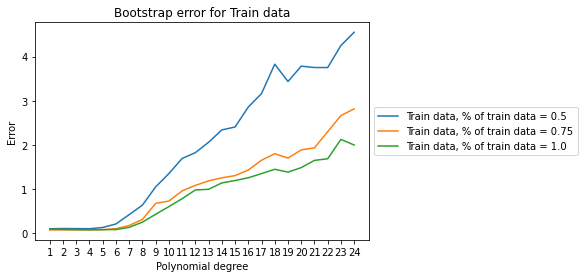

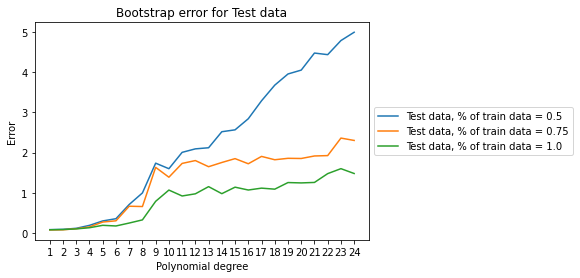

In [9]:
plot_bootstrap(features, labels ,n_datapoints, degree_values, fig_name ='b_bootstrap_withnoise_',n_bootstraps= n_bootstraps, solver = solver, **solver_args )  